In [13]:
from llama_parse import LlamaParse
from llama_index.core import Settings
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import MarkdownElementNodeParser
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.vector_stores.kdbai import KDBAIVectorStore
from getpass import getpass
import kdbai_client as kdbai

from dotenv import load_dotenv

load_dotenv()

True

In [21]:
# llama-parse is async-first, running the async code in a notebook requires the use of nest_asyncio
import nest_asyncio
nest_asyncio.apply()

import os
# API access to llama-cloud
# os.environ["LLAMA_CLOUD_API_KEY"] = os.getenv('LLAMA_CLOUD_API_KEY')

KDBAI_ENDPOINT = (os.environ["KDBAI_ENDPOINT"] if "KDBAI_ENDPOINT" in os.environ else input("KDB.AI endpoint: "))
KDBAI_API_KEY = (os.environ["KDBAI_API_KEY"] if "KDBAI_API_KEY" in os.environ else getpass("KDB.AI API key: "))

#connect to KDB.AI
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

In [22]:
# Connect with kdbai database
db = session.database("default")

In [31]:
# The schema contains two metadata columns (document_id, text) and one embeddings column
schema = [
        dict(name="document_id", type="str"),
        dict(name="text", type="str"),
        dict(name="embeddings", type="float32s"),
    ]

# indexflat, define the index name, type, column to apply the index to (embeddings)
# and params which include thesearch metric (Euclidean distance), and dims
indexFlat = {
        "name": "flat",
        "type": "flat",
        "column": "embeddings",
        "params": {'dims': 1536, 'metric': 'L2'},
    }

KDBAI_TABLE_NAME = "LlamaParse_Table"

# First ensure the table does not already exist
try:
    db.table(KDBAI_TABLE_NAME).drop()
except kdbai.KDBAIException:
    pass

#Create the table
table = db.create_table(table=KDBAI_TABLE_NAME, schema=schema, indexes=[indexFlat])

In [24]:
EMBEDDING_MODEL  = "text-embedding-3-small"
GENERATION_MODEL = "gpt-4o"

llm = OpenAI(model=GENERATION_MODEL)
embed_model = OpenAIEmbedding(model=EMBEDDING_MODEL)

Settings.llm = llm
Settings.embed_model = embed_model

pdf_file_name = './MACRec.pdf'

In [25]:
# parsing_instructions = '''The document titled "LLM In-Context Recall is Prompt Dependent" is an academic preprint from April 2024, authored by Daniel Machlab and Rick Battle from the VMware NLP Lab. It explores the in-context recall capabilities of Large Language Models (LLMs) using a method called "needle-in-a-haystack," where a specific factoid is embedded in a block of unrelated text. The study investigates how the recall performance of various LLMs is influenced by the content of prompts and the biases in their training data. The research involves testing multiple LLMs with varying context window sizes to assess their ability to recall information accurately when prompted differently. The paper includes detailed methodologies, results from numerous tests, discussions on the impact of prompt variations and training data, and conclusions on improving LLM utility in practical applications. It contains many tables. Answer questions using the information in this article and be precise.'''
# print(parsing_instructions)

documents = LlamaParse(
    result_type="markdown", 
    # parsing_instructions=parsing_instructions
).load_data(pdf_file_name)
# print(documents[0].text[:1000])

Started parsing the file under job_id aa583c54-abd1-4eee-947a-f13adbfc51c2
..

In [26]:
for i, doc in enumerate(documents, start=1):
    print(f"{i}".ljust(100, '-'))
    print(doc.text)

1---------------------------------------------------------------------------------------------------
# MACRec: a Multi-Agent Collaboration Framework for Recommendation

Zhefan Wang∗

DCST, Tsinghua University

Beijing 100084, China

wzf23@mails.tsinghua.edu.cn

Yuanqing Yu∗

DCST, Tsinghua University

Beijing 100084, China

yyq23@mails.tsinghua.edu.cn

Wendi Zheng

DCST, Tsinghua University

Beijing 100084, China

zhengwd23@mails.tsinghua.edu.cn

Weizhi Ma†

AIR, Tsinghua University

Beijing 100084, China

mawz@tsinghua.edu.cn

Min Zhang†

DCST, Tsinghua University

Beijing 100084, China

z-m@tsinghua.edu.cn

arXiv:2402.15235v3 [cs.IR] 1 Nov 2024

# ABSTRACT

LLM-based agents have gained considerable attention for their decision-making skills and ability to handle complex tasks. Recognizing the current gap in leveraging agent capabilities for multi-agent collaboration in recommendation systems, we introduce MACRec, a novel framework designed to enhance recommendation systems through mu

In [27]:
# Parse the documents using MarkdownElementNodeParser
node_parser = MarkdownElementNodeParser(llm=llm, num_workers=8).from_defaults()

# Retrieve nodes (text) and objects (table)
nodes = node_parser.get_nodes_from_documents(documents)

base_nodes, objects = node_parser.get_nodes_and_objects(nodes)

# insert the table markdown into the text of each table object
for i in range(len(objects)):
  ㅁ = objects[i].obj.text[:]

0it [00:00, ?it/s]
1it [00:00, 18558.87it/s]
1it [00:00, 15650.39it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [32]:
vector_store = KDBAIVectorStore(table)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

#Create the index, inserts base_nodes and objects into KDB.AI
recursive_index = VectorStoreIndex(
    nodes= base_nodes + objects, storage_context=storage_context
)

# Query KDB.AI to ensure the nodes were inserted
table.query()

,document_id,text,embeddings
0,2b516ba5-4f80-4723-85bd-1210fc2131e4,MACRec: a Multi-Agent Collaboration Framework ...,"[-0.0010586621, 0.041707043, 0.02925757, 0.029..."
1,a6c378f2-ab9d-46fd-89cb-25f4cf62b35e,"SIGIR ’24, July 14–18, 2024, Washington, DC, U...","[-0.0015073667, 0.03517134, 0.057041712, 0.030..."
2,b1dd3c00-1b68-47fc-917d-d2543f7c36a9,Varying requirements for agents in different s...,"[-0.004967418, 0.037573203, 0.04944687, 0.0059..."
3,6a286a2e-717a-4419-a3e3-fd5c173631a3,MACRec: a Multi-Agent Collaboration Framework ...,"[-0.0118856495, 0.06537797, 0.021507366, 0.003..."
4,2ad81017-66f8-4e74-8598-c902244f810c,Code is available at https://github.com/wzf200...,"[-0.018466502, 0.047101013, 0.060254864, 0.020..."
5,dfda5935-52df-4254-98a0-58761eb9b69a,"SIGIR ’24, July 14–18, 2024, Washington, DC, U...","[-0.027369712, 0.04296594, -0.007082258, 0.006..."
6,224ab1d8-a8f7-4fe9-bdb7-e1a7fa37e50b,"Moreover, given that the answers to the sequen...","[-0.013393156, 0.05124579, 0.016177049, 0.0100..."
7,79c2c0d4-1557-43c8-9d29-5fce9c418069,MACRec: a Multi-Agent Collaboration Framework ...,"[-0.02555791, 0.009939187, 0.06459412, 0.02189..."
8,19d54e30-e5e8-40c1-b1c2-7642ac3adb95,arXiv preprint arXiv:2308.09904 (2023).\n12. P...,"[-0.0062998543, 0.022451159, 0.04597343, 0.013..."
9,5e1b00ab-6c49-417f-80ac-d812d56e0501,2022. Glm-130b: An open bilingual pre-trained ...,"[-0.0017179978, -0.0010304812, 0.04113033, 0.0..."


In [33]:
from openai import OpenAI
client = OpenAI()

def embed_query(query):
    query_embedding = client.embeddings.create(
            input=query,
            model="text-embedding-3-small"
        )
    return query_embedding.data[0].embedding

def retrieve_data(query):
    query_embedding = embed_query(query)
    results = table.search(vectors={'flat':[query_embedding]},n=5,filter=[('<>','document_id','4a9551df-5dec-4410-90bb-43d17d722918')])
    retrieved_data_for_RAG = []
    for index, row in results[0].iterrows():
      retrieved_data_for_RAG.append(row['text'])
    return retrieved_data_for_RAG

def RAG(query):
  question = "You will answer this question based on the provided reference material: " + query
  messages = "Here is the provided context: " + "\n"
  results = retrieve_data(query)
  if results:
    for data in results:
      messages += data + "\n"
  response = client.chat.completions.create(
      model="gpt-4o",
      messages=[
          {"role": "system", "content": question},
          {
          "role": "user",
          "content": [
              {"type": "text", "text": messages},
          ],
          }
      ],
      # max_tokens=300,
  )
  content = response.choices[0].message.content
  return content

In [36]:
print(RAG("이 논문의 핵심은 뭐야? 본문의 내용을 인용/발췌해서 설명해줘. 한글로 대답해."))

이 논문의 핵심은 MACRec이라는 새로운 프레임워크를 소개하는 것입니다. MACRec는 LLM 기반의 다중 에이전트 협업 프레임워크로, 추천 시스템에서의 멀티 에이전트 협업을 통해 추천 작업을 직접적으로 해결하는 것을 목표로 합니다. 이 프레임워크는 매니저, 사용자/아이템 분석가, 반성자, 탐색자, 작업 해석자와 같은 여러 전문화된 에이전트들의 협력을 통해 추천 작업을 수행합니다. MACRec는 평가 예측, 순차적 추천, 대화형 추천, 추천 결과 설명 생성과 같은 다양한 추천 작업에 쉽게 활용할 수 있습니다. 이 프레임워크는 특히 단일 에이전트가 수행하기 어려운 복잡한 의사결정 작업에서 유용하며, 인간의 작업 흐름에 가까운 다중 에이전트 협업이 이를 보다 효과적으로 수행할 수 있다고 설명합니다. "In this work, we propose a novel LLM-based multi-agent collaboration framework for recommendation, called MACRec. Unlike existing studies on using agents for user/item simulation, we directly tackle recommendation tasks through the collaboration of various agents."(본문에서 발췌)


# Reference 파싱

In [37]:
answer = RAG(f"""Find this paper's References. Give me that References with the given json form. Don't return any other comments except that References

EXAMPLE : 
{{
    1 : {{
    "Title" : "Language models are few-shot learners",
    "Author(s)" : "Tom Brown, Benjamin Mann, Nick Ryder, Melanie Subbiah, Jared D Kaplan, Prafulla Dhariwal, Arvind Neelakantan, Pranav Shyam, Girish Sastry, Amanda Askell, et al",
    "Conference" : "Advances in neural information processing systems 33 (2020), 1877–1901"
    }},
    2 : {{
        ...
    }},
    ...
}}
""")

In [38]:
ref_dict = eval(answer.replace("```json\n", "").replace("```", ""))

In [39]:
ref_dict

{1: {'Title': 'Language models are few-shot learners',
  'Author(s)': 'Tom Brown, Benjamin Mann, Nick Ryder, Melanie Subbiah, Jared D Kaplan, Prafulla Dhariwal, Arvind Neelakantan, Pranav Shyam, Girish Sastry, Amanda Askell, et al.',
  'Conference': 'Advances in neural information processing systems 33 (2020), 1877–1901'},
 2: {'Title': 'Trends in distributed artificial intelligence',
  'Author(s)': 'Brahim Chaib-Draa, Bernard Moulin, René Mandiau, and Patrick Millot',
  'Conference': 'Artificial Intelligence Review 6 (1992), 35–66'},
 3: {'Title': 'Agentverse: Facilitating multi-agent collaboration and exploring emergent behaviors in agents',
  'Author(s)': 'Weize Chen, Yusheng Su, Jingwei Zuo, Cheng Yang, Chenfei Yuan, Chen Qian, Chi-Min Chan, Yujia Qin, Yaxi Lu, Ruobing Xie, et al.',
  'Conference': 'arXiv preprint arXiv:2308.10848 (2023)'},
 4: {'Title': 'Improving Factuality and Reasoning in Language Models through Multiagent Debate',
  'Author(s)': 'Yilun Du, Shuang Li, Antonio T

## get_citation_count


In [177]:
from scholarly import scholarly

PAPER_COMPARE_PROMPT = """Do the two papers refer to the same paper? If yes, answer YES; otherwise, answer NO.
- If the paper titles are completely identical, assume they refer to the same paper.
- Authors may vary. For example, they might use abbreviations or list some as company names and others as individuals. In such cases, keep this in mind when making your judgment.
          
          A paper title : {a_paper_title}
          A paper authors : {a_paper_authors}
          
          B paper title : {b_paper_title}
          B paper authors : {b_paper_authors}"""

def get_citation_count(ref_paper_title, ref_paper_authors, author=None):
    # Google Scholar에서 논문 검색
    search_query = scholarly.search_pubs(ref_paper_title)
    cnt = 0
    if not len(search_query._rows):
        return None
    for result in search_query:
        cnt += 1
        b_paper_title = result['bib']['title']
        b_paper_authors = ', '.join(result['bib']['author'])
        if paper_compare(ref_paper_title, ref_paper_authors, b_paper_title, b_paper_authors) == 'YES':
            citation_count = result.get('num_citations', 0)  # 인용수 가져오기
            return citation_count
        if cnt >= 20:
            return None

def paper_compare(ref_paper_title, ref_paper_authors, b_paper_title, b_paper_authors):
    print(f"\tΓref_paper_title : {ref_paper_title}\n\tL  b_paper_title : {b_paper_title}")
    prompt = PAPER_COMPARE_PROMPT.format(
                    a_paper_title=ref_paper_title,
                    a_paper_authors=ref_paper_authors,
                    b_paper_title=b_paper_title,  # 오타 수정
                    b_paper_authors=b_paper_authors
    )
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": prompt
            },
        ]
    )
    answer = response.choices[0].message.content
    print(f"\t{answer}")
    return answer

In [186]:
for i, one_ref_info in ref_dict.items():
    ref_paper_title = one_ref_info['Title']
    ref_paper_authors = one_ref_info['Author(s)']
    print(f"".ljust(120, '-'))
    citation_cnt = get_citation_count(ref_paper_title, ref_paper_authors)
    if citation_cnt is not None:
        print(f"[{citation_cnt:10,}] [{i}] {ref_paper_title}")
        ref_dict[i]['citation_count'] = {
            'value' : citation_cnt,
            'date' : datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }
    else:
        print(f"[{'None':10}] [{i}] {ref_paper_title}")
        ref_dict[i]['citation_count'] = {
            'value' : citation_cnt,
            'date' : datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

------------------------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

# 그래프 그리기

In [199]:
one_ref['citation_count']['value'] is not None:

38863

In [200]:
ref_dict_w_cnt = {}
for i, one_ref in ref_dict.items():
    if ('citation_count' in one_ref) and (one_ref['citation_count']['value'] is not None):
        ref_dict_w_cnt[i] = one_ref

In [ ]:
{
  'Title': 'MACRec: A Multi-Agent Collaboration Framework for Recommendation',
  'Author(s)': 'Z. Wang, Y. Yu, W. Zheng, W. Ma, M. Zhang',
  'Conference': 'Proceedings of the 47th International ACM SIGIR Conference on Research and Development in Information Retrieval (2024, July), 2760-2764',
  'citation_count': {'value': 'unknown', 'date': '2025-01-22 16:50:59'}
}


In [201]:
ref_dict_w_cnt

{1: {'Title': 'Language models are few-shot learners',
  'Author(s)': 'Tom Brown, Benjamin Mann, Nick Ryder, Melanie Subbiah, Jared D Kaplan, Prafulla Dhariwal, Arvind Neelakantan, Pranav Shyam, Girish Sastry, Amanda Askell, et al.',
  'Conference': 'Advances in neural information processing systems 33 (2020), 1877–1901',
  'citation_count': {'value': 38863, 'date': '2025-01-22 16:50:59'}},
 3: {'Title': 'Agentverse: Facilitating multi-agent collaboration and exploring emergent behaviors in agents',
  'Author(s)': 'Weize Chen, Yusheng Su, Jingwei Zuo, Cheng Yang, Chenfei Yuan, Chen Qian, Chi-Min Chan, Yujia Qin, Yaxi Lu, Ruobing Xie, et al.',
  'Conference': 'arXiv preprint arXiv:2308.10848 (2023)',
  'citation_count': {'value': 155, 'date': '2025-01-22 16:51:04'}},
 4: {'Title': 'Improving Factuality and Reasoning in Language Models through Multiagent Debate',
  'Author(s)': 'Yilun Du, Shuang Li, Antonio Torralba, Joshua B Tenenbaum, and Igor Mordatch',
  'Conference': 'arXiv preprint

Matplotlib is building the font cache; this may take a moment.


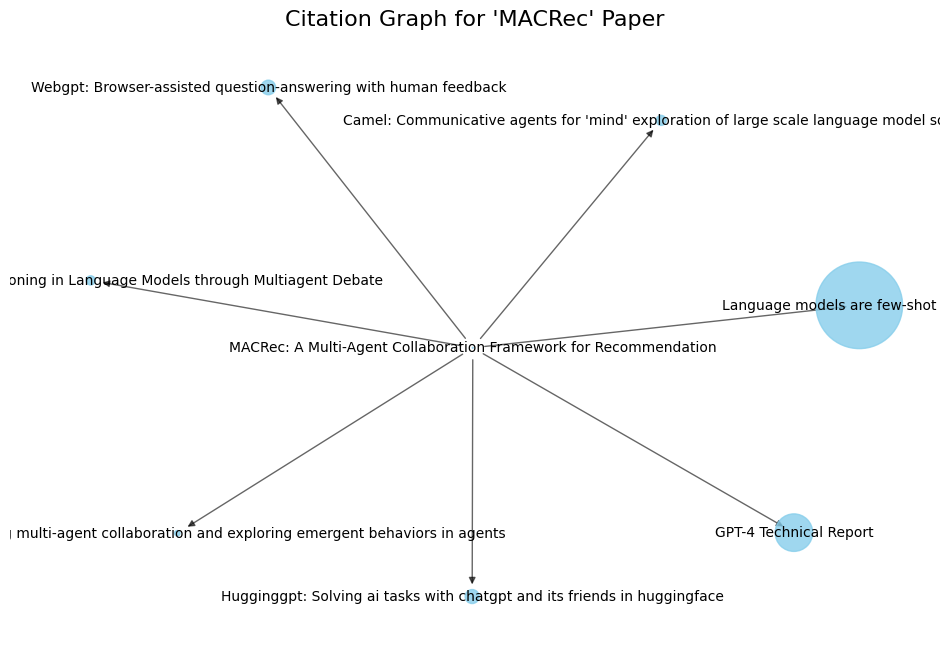

In [213]:
import matplotlib.pyplot as plt
import networkx as nx

# Main paper
main_paper = {
    'Title': 'MACRec: A Multi-Agent Collaboration Framework for Recommendation',
    'citation_count': {'value': 4, 'date': '2025-01-22 16:50:59'}
}

# Cited papers
cited_papers = {
    1: {'Title': 'Language models are few-shot learners', 'citation_count': {'value': 38863, 'date': '2025-01-22 16:50:59'}},
    3: {'Title': 'Agentverse: Facilitating multi-agent collaboration and exploring emergent behaviors in agents', 'citation_count': {'value': 155, 'date': '2025-01-22 16:51:04'}},
    4: {'Title': 'Improving Factuality and Reasoning in Language Models through Multiagent Debate', 'citation_count': {'value': 437, 'date': '2025-01-22 16:51:06'}},
    6: {'Title': "Camel: Communicative agents for 'mind' exploration of large scale language model society", 'citation_count': {'value': 523, 'date': '2025-01-22 16:51:11'}},
    7: {'Title': 'Webgpt: Browser-assisted question-answering with human feedback', 'citation_count': {'value': 1100, 'date': '2025-01-22 16:51:13'}},
    9: {'Title': 'GPT-4 Technical Report', 'citation_count': {'value': 7299, 'date': '2025-01-22 16:51:17'}},
    10: {'Title': 'Hugginggpt: Solving ai tasks with chatgpt and its friends in huggingface', 'citation_count': {'value': 1016, 'date': '2025-01-22 16:51:20'}}
}

# Create a directed graph
G = nx.DiGraph()

# Add the main paper node
main_title = main_paper['Title']
main_citation_count = main_paper['citation_count']['value']
G.add_node(main_title, size=main_citation_count)

# Add cited papers as nodes and edges
for key, paper in cited_papers.items():
    title = paper['Title']
    citation_count = paper['citation_count']['value']
    G.add_node(title, size=citation_count)
    G.add_edge(main_title, title)

# Draw the graph
plt.figure(figsize=(12, 8))

# Get node sizes from citation counts
node_sizes = [G.nodes[node]['size'] for node in G.nodes]

# Draw the graph with node sizes proportional to citation counts
pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistency
nx.draw_networkx_nodes(G, pos, node_size=[size / 10 for size in node_sizes], node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title("Citation Graph for 'MACRec' Paper", fontsize=16)
plt.axis('off')
plt.show()


# Requests

In [205]:
import requests
from bs4 import BeautifulSoup

# Google Scholar 검색 URL
query = "MACRec: A Multi-Agent Collaboration Framework for Recommendation"
url = f"https://scholar.google.com/scholar?q={query}"

# 요청 헤더 설정 (실제 브라우저에서의 요청처럼 위장)
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

# GET 요청 보내기
response = requests.get(url, headers=headers)

# 상태 코드 확인
if response.status_code == 200:
    # HTML 파싱
    soup = BeautifulSoup(response.text, "html.parser")

    # 논문 제목과 관련 정보 추출
    results = soup.select(".gs_ri")
    for i, result in enumerate(results):
        title = result.select_one(".gs_rt").text
        authors_and_year = result.select_one(".gs_a").text
        snippet = result.select_one(".gs_rs").text if result.select_one(".gs_rs") else "No snippet available"
        link = result.select_one(".gs_rt a")["href"] if result.select_one(".gs_rt a") else "No link available"

        print(f"Result {i+1}:")
        print(f"Title: {title}")
        print(f"Authors and Year: {authors_and_year}")
        print(f"Snippet: {snippet}")
        print(f"Link: {link}")
        print("-" * 80)
else:
    print(f"Failed to fetch the page. Status code: {response.status_code}")


In [204]:
results

[]

In [206]:
# 응답 HTML 저장 및 확인
with open("response.html", "w", encoding="utf-8") as f:
    f.write(response.text)

print("Response saved to response.html. Open it in a browser to check if it's a Captcha page.")


Response saved to response.html. Open it in a browser to check if it's a Captcha page.


# References

https://medium.com/kx-systems/rag-llamaparse-advanced-pdf-parsing-for-retrieval-c393ab29891b

https://www.devkuma.com/docs/d3-js/append/